## Modeling<a id='Modeling'>

## Contents<a id='Contents'></a>
* [Modeling](#Modeling)
  * [Contents](#Contents)
  * [Introduction](#Introduction)
  * [Imports](#Imports)
  * [Summary of baseline logisticRegression model](#summarized_results)
  * [Load Data](#Load_Data)
  * [LogisticRegression algorithm](#logistic_regression)
  * [roc_auc_score and ROC Curve](#roc_related)
* [SMOTE](#smote)
     * [Fitting Logistic Regression after SMOTE](#logreg_smote)
     * [Fitting RandomForest classifier after SMOTE](#rfc_smote)
     * [Fitting AdaBoost classifier after SMOTE](#adaboost_smote)
* [Undersampling](#undersampling) 
    * [Fitting LogisticRegression with undersampling](#logreg_undersample)
    * [Fitting RandomForest Classifier with undersampling](#rfc_undersampling)
    * [Fitting AdaBoost Classifier with undersampling](#abc_undersampling)
* [Summarized classification reports for 3 algorithms](#summary_charts_all)
* [Applying StratifiedKFold cross-validator](#stratifiedkfold_cv)
    * [Cross_validate LogisticRegression model](#cv_logreg)
    * [Cross_validate RandomForestClassifier Model](#cv_rfc)
    * [Best Parameters for RandomForestClassifier](#best_params_rfc)
    * [Finding parameters for AdaBoost Classifier Model](#best_params_ada)
    * [Cross_validate with AdaBoost Classifier](#cv_ada)

### Introduction<a id='Introduction'>

* In the first round of
the modeling notebook use the probability output and
a threshold other than 0.5, which is the default.
* I am choosing binary model first.<br/>
<b>We will follow the same pattern we used before, only this time we are explicitly defining two objects ``X`` and ``y``, which were defined implicitly when we built the first model</b>. 

    
Thus, pattern defined above can be expanded as follows:

> (a) Define ``X`` and ``y``  

> (b) Perform train/test split on ``(X, y)``  

> (c) Create an object of the class associated with the algorithm to be used--in this case ``LogisticRegression``  

> (d) Build an actual model using the``fit`` method from the class associated with the algorithm 
to be used (using the training set)  

> (e) Predict with the built model using the``predict`` method from the class (training set and test set)  

> (f) Compute performance metrics (in this case, accuracy) for the training and test predictions. The metrics to be used and their interpretation will depend on the application at hand  

> (g) Determine if the model can be improved--repeat as needed with additional algorithms and/or by applying hyper-parameter tuning  

> (h) Compare and Combine all best models as needed

### Imports<a id='Imports'>

In [380]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from library.sb_utils import save_file

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import nltk
# Remove tokens that do not contain any letters from words_tokenized
import re
from nltk.stem.snowball import SnowballStemmer
# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from numpy import arange
from numpy import argmax
#reasampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#one more method of train test split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
from sklearn.pipeline import make_pipeline
#
print("Loaded Libraries")
import warnings
warnings.simplefilter("ignore")

Loaded Libraries


## Summary of baseline logisticRegression model<a id='summarized_results'>

<table style="background-color: #D6EEEE">
    <tr><th>Model</th><th>classes</th><th>Precision</th><th>Recall</th><th>f1-score</th><th>support</th></tr>
    <tr><td rowspan="3">MultiClass LogReg Training</td><td>0</td><td>0.89</td><td>0.99</td><td>0.94</td><td>12387</td></tr>
    <tr><td>1</td><td>0.86</td><td>0.71</td><td>0.78</td><td>1790</td></tr>
    <tr><td>2</td><td>0.76</td><td>0.25</td><td>0.38</td><td>1580</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.89</th><th>15757</th></tr>
    <tr><td rowspan="3">MultiClass LogReg Test Set</td><td>0</td><td>0.88</td><td>0.99</td><td>0.93</td><td>3097</td></tr>
    <tr><td>1</td><td>0.77</td><td>0.60</td><td>0.67</td><td>448</td></tr>
    <tr><td>2</td><td>0.61</td><td>0.19</td><td>0.29</td><td>395</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.86</th><th>3940</th></tr>
    <tr><td rowspan="2">Binary LogReg Training</td><td>0</td><td>0.95</td><td>0.99</td><td>0.97</td><td>13967</td></tr>
    <tr><td>1</td><td>0.91</td><td>0.55</td><td>0.68</td><td>1790</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.94</th><th>15757</th></tr>
    <tr><td rowspan="2">Binary LogReg Test Set</td><td>0</td><td>0.93</td><td>0.99</td><td>0.96</td><td>3492</td></tr>
    <tr><td>1</td><td>0.81</td><td>0.46</td><td>0.59</td><td>448</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.93</th><th>3940</th></tr>
    </table>

Note: if we observe the summary chart, we can see that recall score is low for the minority class. One possible reason is calsses are hihgly imbalanced. TO take care of that, I will apply sampling method(one undersampling and one oversampling method) for three models that I choose. The three models i am choosing will be Logistic Regression, random Forest and AdaBoost Classifier. And I will be considering only binary classification instead of multiclass classification. 

### Load Data<a id='Load_Data'>

In [8]:
df_main = pd.read_csv('cp2_ppt_2_sentiment_df.csv')

In [9]:
df_main.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,categories,review_id,user_id,yelp_review_stars,useful,funny,cool,text,date,year,text_length
0,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",WeTHLEdLdP3Y3AXWWCsx4g,UizCd11Qoo74BKARrZp7HA,5,0,0,1,We are visiting in Philadelphia from Californi...,2018-05-28 21:27:38,2018,614
1,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",MrWpfvjVA6Qtj3CDvFfPiA,49aswoS-d09tyWNJimzZ5A,5,1,0,0,Delicious food ! I personally loved it !!!\n\n...,2018-02-01 19:28:41,2018,573
2,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",hll3PKZbMbu2W7uFbF8ezQ,CmLK8cjvcUIKyNVMp8ZyDA,2,0,0,0,Beautiful place. Excellent food. I only gave i...,2018-08-24 13:30:41,2018,362
3,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",Mi5lScAdCWuJZj0QO_4qxg,wG77jgwRg53rN1KVxo637w,2,0,0,0,"It's extremely overpriced, and the sandwiches ...",2018-02-11 18:04:01,2018,254
4,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",SSu94Tvc6L5UBC4FDDyAbw,5s0nTuLRm3ue4Qfrj9PHkQ,5,0,0,0,Instagram worthy and Claire is an amazing serv...,2018-05-28 23:07:50,2018,1167


In [10]:
# Create new column "target_binary" that stored 0's or 1's. 0 being Positive, 1 being Non-Positive
df_main["target_binary"] = np.where(df_main["yelp_review_stars"] >= 3, 0, 1)
df_main.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,categories,...,user_id,yelp_review_stars,useful,funny,cool,text,date,year,text_length,target_binary
0,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",...,UizCd11Qoo74BKARrZp7HA,5,0,0,1,We are visiting in Philadelphia from Californi...,2018-05-28 21:27:38,2018,614,0
1,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",...,49aswoS-d09tyWNJimzZ5A,5,1,0,0,Delicious food ! I personally loved it !!!\n\n...,2018-02-01 19:28:41,2018,573,0
2,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eas...",...,CmLK8cjvcUIKyNVMp8ZyDA,2,0,0,0,Beautiful place. Excellent food. I only gave i...,2018-08-24 13:30:41,2018,362,1


In [16]:
# Picking the only text and target column
df_bi_final = df_main[['text','target_binary']]

In [17]:
df_bi_final.head()

,text,target_binary
0,We are visiting in Philadelphia from Californi...,0
1,Delicious food ! I personally loved it !!!\n\n...,0
2,Beautiful place. Excellent food. I only gave i...,1
3,"It's extremely overpriced, and the sandwiches ...",1
4,Instagram worthy and Claire is an amazing serv...,0


In [18]:
import re 
def function_clean(text):
    text = re.sub(r"http\S+", "", text) #removing the URL Http
    # Removal of mentions
    text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub("'s", "", text)   
    return text

In [23]:
# Define a function to perform both stemming and tokenization


def tokenize_and_stem(text):

    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]

    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]',token)]

    stems = [stemmer.stem(token) for token in filtered_tokens]

    return stems

In [19]:
# applying the cleaning function to text column
df_bi_final['text'] = df_bi_final['text'].apply(lambda text: function_clean(text))

In [20]:
df_bi_final.head()

,text,target_binary
0,We are visiting in Philadelphia from Californi...,0
1,Delicious food I personally loved it I was sur...,0
2,Beautiful place Excellent food I only gave it ...,1
3,It s extremely overpriced and the sandwiches a...,1
4,Instagram worthy and Claire is an amazing serv...,0


In [21]:
X_train,X_test,y_train,y_test = train_test_split(df_bi_final['text'], df_bi_final['target_binary'], random_state=2, test_size=0.2, stratify = df_bi_final['target_binary'])

In [22]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15757,), (3940,), (15757,), (3940,))

In [24]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text

tfidf = TfidfVectorizer(stop_words='english',tokenizer=tokenize_and_stem,ngram_range=(1,1))

In [25]:
X_train_transformed = tfidf.fit_transform(X_train)

In [26]:
type(X_train_transformed)

scipy.sparse.csr.csr_matrix

In [29]:
X_test_transformed = tfidf.transform(X_test)

In [30]:
type(X_test_transformed)

scipy.sparse.csr.csr_matrix

In [194]:
y_train.value_counts()

0    13967
1     1790
Name: target_binary, dtype: int64

In [195]:
y_test.value_counts()

0    3492
1     448
Name: target_binary, dtype: int64

## LogisticRegression algorithm<a id='logistic_regression'>
    
Logistic Regression algorithm is ussed to build models that are simple and yet effecive--in some cases. This algorithm can be used to build useful baseline models for classification problems that can be easily interpreted. For these reasons, Logistic Regression is considered as one of the fundamental Machine Learning algorithms associated with classification problems.

In [36]:
# fit a model
clf = LogisticRegression()
clf.fit(X_train_transformed, y_train)
# predict labels
y_pred = model.predict(X_test_transformed)


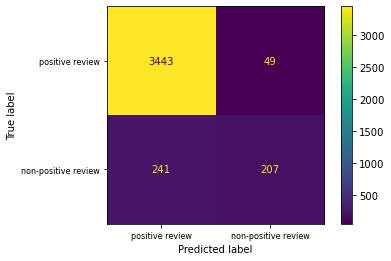

In [38]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['positive review', 'non-positive review'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
ax.set_yticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
display_cm.plot(ax = ax)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3492
           1       0.81      0.46      0.59       448

    accuracy                           0.93      3940
   macro avg       0.87      0.72      0.77      3940
weighted avg       0.92      0.93      0.92      3940



Based on the above classification report we observe that we are predicting more false positive results. Thus our goal is build a model which will increase the recall score above  0.46 for class 1 which is the minority class. if we predict class 1 correctly then the business can get a chance to improve.  

## roc_auc_score and ROC Curve<a id='roc_related'>

Another common metric is AUC, area under the receiver operating characteristic (ROC) curve. The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

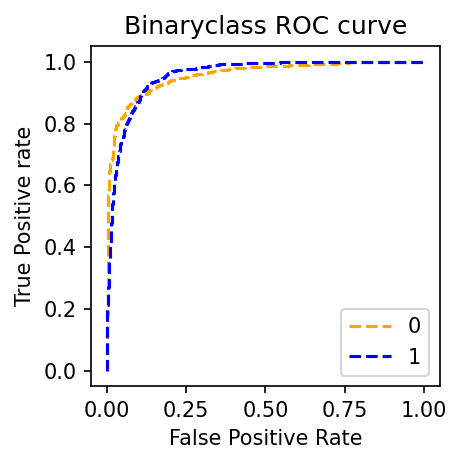

In [105]:

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:,i], pos_label=i)
    
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0')
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='1')

plt.title('Binaryclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Binary Class ROC',dpi=300); 

In [118]:
roc_auc_score(y_test, clf.predict_proba(X_test_transformed)[:, 1])

0.9573444659221076

In [122]:
roc_auc_score(y_train, clf.predict_proba(X_train_transformed)[:, 1])

0.9818124965751274

Before applying resampling method, I will try to fit two more models namels RandomForestClassifier and AdaBoost

## Applying two algorithms before sampling<a id='apply_before sampling'>

## RandomForest Classifier Algorithm<a id='random_algorithm_before_sampling'>
    
   Follows Bootstrap Aggregation method - Bagging

In [127]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_transformed,y_train)
y_pred_rfc = rfc_model.predict(X_test_transformed)


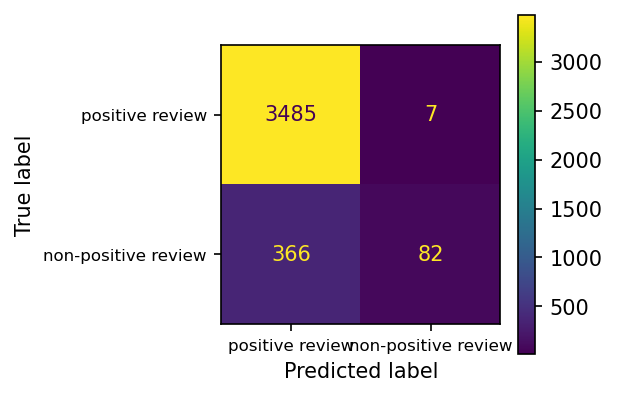

In [128]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc, labels = rfc_model.classes_)
_, ax = plt.subplots()
display_cm_rfc = ConfusionMatrixDisplay(confusion_matrix = cm_rfc, 
                                    display_labels = ['positive review', 'non-positive review'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
ax.set_yticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
display_cm_rfc.plot(ax = ax)

In [129]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3492
           1       0.92      0.18      0.31       448

    accuracy                           0.91      3940
   macro avg       0.91      0.59      0.63      3940
weighted avg       0.91      0.91      0.88      3940



## AdaBoost Classifier Algorithm<a id='adaboost_algorithm_before_sampling'>
     Boosting Method
    AdaBoost - Adaptive Boosting ALgorithm

In [130]:
from sklearn.ensemble import AdaBoostClassifier

In [134]:
# Create adaboost classifer object
abc_model = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
# Train Adaboost Classifer
abc_model.fit(X_train_transformed, y_train)

#Predict the response for test dataset
y_pred_abc = abc_model.predict(X_test_transformed)

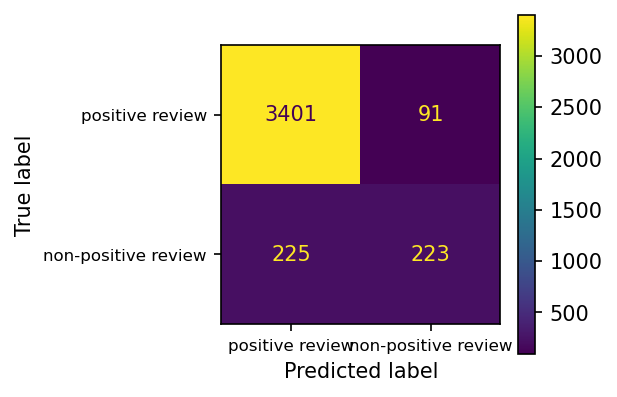

In [135]:
cm_abc = confusion_matrix(y_test, y_pred_abc, labels = abc_model.classes_)
_, ax = plt.subplots()
display_cm_abc = ConfusionMatrixDisplay(confusion_matrix = cm_abc, 
                                    display_labels = ['positive review', 'non-positive review'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
ax.set_yticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
display_cm_abc.plot(ax = ax)

In [136]:
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3492
           1       0.71      0.50      0.59       448

    accuracy                           0.92      3940
   macro avg       0.82      0.74      0.77      3940
weighted avg       0.91      0.92      0.91      3940



### Summary of three models - before any sampling techniques

<table>
    <tr><th>Model</th><th>classes</th><th>Precision</th><th>Recall</th><th>f1-score</th><th>support</th></tr>
   <tr><td rowspan="2">Before sampling - LogisticRegression</td><td>0</td><td>0.93</td><td>0.99</td><td>0.96</td><td>3492</td></tr>
   
   <tr><td>1</td><td>0.81</td><td>0.46</td><td>0.59</td><td>448</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.93</th><th>3940</th></tr>
    <tr><td rowspan="2">Before sampling - RandomForest</td><td>0</td><td>0.90</td><td>1.00</td><td>0.95</td><td>3492</td></tr>
    <tr><td>1</td><td>0.92</td><td>0.18</td><td>0.31</td><td>448</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.91</th><th>3940</th></tr>
    <tr><td rowspan="2">Before sampling - AdaBoost</td><td>0</td><td>0.94</td><td>0.97</td><td>0.96</td><td>3492</td></tr>
    <tr><td>1</td><td>0.71</td><td>0.50</td><td>0.59</td><td>448</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.92</th><th>3940</th></tr>  
</table>

WE have to increase the Recall score. For that, we need to balance our target classes. We have a hunge target imbalance where positie classes(class 0) is 89% and negative classes (class 1) is 11%. I will apply one undersampling and one oversampling technique and test it for each model and then compare their recall scores and overall predcition score.

Let us apply oversampling method first. I wil use SMOTE.

## SMOTE<a id='smote'>

In [139]:
#Binary SMOTE the training data
sm = SMOTE(random_state=1)
X_2_bal, y_2_bal = sm.fit_resample(X_train_transformed, y_train)

In [140]:
y_2_bal.value_counts()

0    13967
1    13967
Name: target_binary, dtype: int64

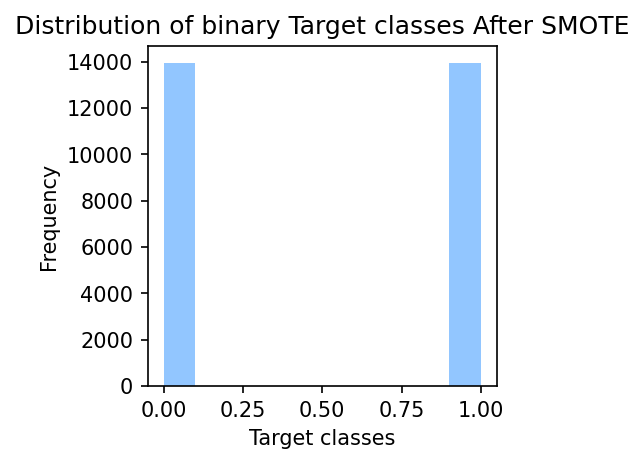

In [141]:
ax=y_2_bal.hist(grid=False)
ax.set_xlabel('Target classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of binary Target classes After SMOTE')
plt.show()

## Fitting Logistic Regression with SMOTE<a id='logreg_smote'>

In [266]:
# Fitting Logistic regression to the training set
logreg_sm = LogisticRegression(solver='lbfgs',random_state=1)
logreg_sm.fit(X_2_bal, y_2_bal)

#predict test set

#pred_labels_sm_train_logit = logreg_sm.predict(X_2_bal)
pred_labels_sm_logit = logreg_sm.predict(X_test_transformed)

# test score
#print(f"Score on training set: {logreg_sm.score(X_train_transformed,y_train)}")
print(f"Score on test set: {logreg_sm.score(X_test_transformed,y_test)}")

Score on test set: 0.9027918781725889


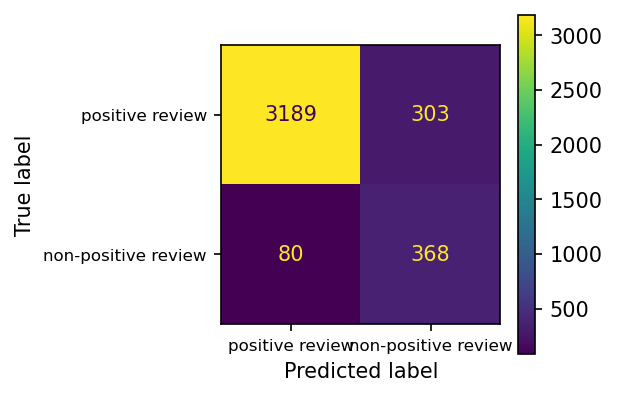

In [144]:
cm_sm = confusion_matrix(y_test, pred_labels_sm_logit, labels = logreg_sm.classes_)
_, ax = plt.subplots()
display_cm_sm = ConfusionMatrixDisplay(confusion_matrix = cm_sm, 
                                    display_labels = ['positive review', 'non-positive review'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
ax.set_yticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
display_cm_sm.plot(ax = ax)

In [147]:
print(classification_report(y_test, pred_labels_sm_logit))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3492
           1       0.55      0.82      0.66       448

    accuracy                           0.90      3940
   macro avg       0.76      0.87      0.80      3940
weighted avg       0.93      0.90      0.91      3940



Based on the above results, I can say that the recall score on the test set improved by 2x from 0.46 to 0.82. Accuracy did drop a bit.

## Fitting RandomForest classifier with SMOTE<a id='rfc_smote'>

In [148]:
rfc_sm_model = RandomForestClassifier()
rfc_sm_model.fit(X_2_bal,y_2_bal)
y_pred_sm_rfc = rfc_sm_model.predict(X_test_transformed)

# Training score
print(f"Score on training set: {rfc_sm_model.score(X_train_transformed,y_train)}")
print(f"Score on test set: {rfc_sm_model.score(X_test_transformed,y_test)}")

Score on training set: 0.9996826807133338
Score on test set: 0.9197969543147209


In [149]:
print(classification_report(y_test, y_pred_sm_rfc))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3492
           1       0.71      0.50      0.59       448

    accuracy                           0.92      3940
   macro avg       0.82      0.74      0.77      3940
weighted avg       0.91      0.92      0.91      3940



Random Foret Classifier performed very good with SMOTE. Recall imporved a lot from 0.18 to 0.5 and accuracy also increased by 0.01.

## Fitting AdaBoost classifier with SMOTE<a id='adaboost_smote'>

In [150]:
abc_sm_model = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
abc_sm_model.fit(X_2_bal,y_2_bal)
y_pred_abc_sm_rfc = abc_sm_model.predict(X_test_transformed)

# Training score
print(f"Score on training set: {abc_sm_model.score(X_train_transformed,y_train)}")
print(f"Score on test set: {abc_sm_model.score(X_test_transformed,y_test)}")

Score on training set: 0.8817668337881577
Score on test set: 0.8758883248730964


In [151]:
print(classification_report(y_test, y_pred_abc_sm_rfc))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      3492
           1       0.47      0.74      0.58       448

    accuracy                           0.88      3940
   macro avg       0.72      0.82      0.75      3940
weighted avg       0.91      0.88      0.89      3940



Recall certainly improved from 0.5 to 0.74. However, accuracy dropped down by 0.04 points. 

## Undersampling<a id='undersampling'>

In [152]:

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_transformed, y_train)

In [153]:
y_res.value_counts()

0    1790
1    1790
Name: target_binary, dtype: int64

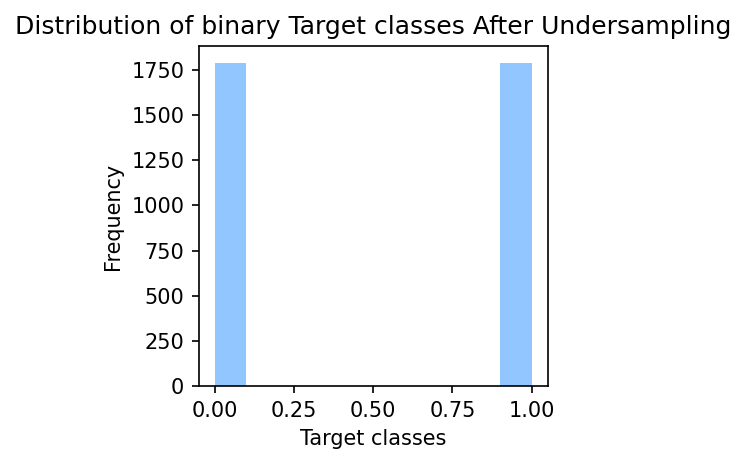

In [154]:
ax=y_res.hist(grid=False)
ax.set_xlabel('Target classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of binary Target classes After Undersampling')
plt.show()

## Fitting Logistic Regression with Undersampling<a id='logreg_undersample'>

In [267]:
# Fitting Logistic regression to the training set
logreg_us = LogisticRegression(solver='lbfgs',random_state=1)
logreg_us.fit(X_res, y_res)

#predict test set

#pred_labels_us_train_logit = logreg_us.predict(X_res)
pred_labels_us_logit = logreg_us.predict(X_test_transformed)

# Test score
#print(f"Score on training set: {logreg_us.score(X_train_transformed,y_train)}")
print(f"Score on test set: {logreg_us.score(X_test_transformed,y_test)}")

Score on test set: 0.8763959390862944


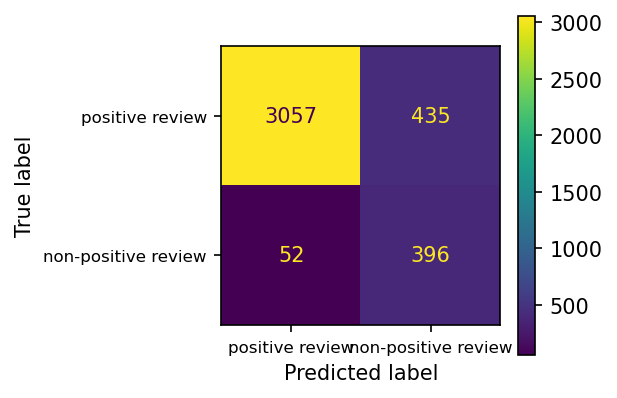

In [159]:
cm_us = confusion_matrix(y_test, pred_labels_us_logit, labels = logreg_us.classes_)
_, ax = plt.subplots()
display_cm_us = ConfusionMatrixDisplay(confusion_matrix = cm_us, 
                                    display_labels = ['positive review', 'non-positive review'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
ax.set_yticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
display_cm_us.plot(ax = ax)

In [158]:
print(classification_report(y_test, pred_labels_us_logit))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3492
           1       0.48      0.88      0.62       448

    accuracy                           0.88      3940
   macro avg       0.73      0.88      0.77      3940
weighted avg       0.93      0.88      0.89      3940



## Fitting RandomForest Classifier with undersampling<a id='rfc_undersampling'>

In [268]:
rfc_us_model = RandomForestClassifier()
rfc_us_model.fit(X_res,y_res)
y_pred_us_rfc = rfc_us_model.predict(X_test_transformed)

# Test score
#print(f"Score on training set: {rfc_us_model.score(X_train_transformed,y_train)}")
print(f"Score on test set: {rfc_us_model.score(X_test_transformed,y_test)}")

Score on test set: 0.8512690355329949


In [161]:
print(classification_report(y_test, y_pred_us_rfc))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3492
           1       0.43      0.88      0.58       448

    accuracy                           0.86      3940
   macro avg       0.71      0.87      0.75      3940
weighted avg       0.92      0.86      0.88      3940



## Fitting AdaBoost Classifier with undersampling<a id='abc_undersampling'>

In [269]:
abc_us_model = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
abc_us_model.fit(X_res,y_res)
y_pred_abc_us_rfc = abc_us_model.predict(X_test_transformed)

# Test score
#print(f"Score on training set: {abc_us_model.score(X_train_transformed,y_train)}")
print(f"Score on test set: {abc_us_model.score(X_test_transformed,y_test)}")

Score on test set: 0.8309644670050761


In [163]:
print(classification_report(y_test, y_pred_abc_us_rfc))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      3492
           1       0.39      0.83      0.53       448

    accuracy                           0.83      3940
   macro avg       0.68      0.83      0.71      3940
weighted avg       0.91      0.83      0.86      3940



In [362]:
#trying out different attributes for classification_report
print(classification_report(y_test, y_pred_abc_us_rfc,labels=[1],target_names=[ 'NEGATIVE']))

              precision    recall  f1-score   support

    NEGATIVE       0.39      0.83      0.53       448

   micro avg       0.39      0.83      0.53       448
   macro avg       0.39      0.83      0.53       448
weighted avg       0.39      0.83      0.53       448



## Summarized classification reports for 3 algorithms<a id='summary_charts_all'>
    
**NOTE: I am considering only class1 here to display as we want to see and compare for class 1 and see if recall score got improved with any of these three algorithms

<table>
<tr><th>Model</th><th>Sampling Technique</th><th>classes</th><th>Precision</th><th>Recall</th><th>f1-score</th><th>support</th></tr>
    <tr><td rowspan="3">LogisticRegression</td><td>No technique(imbalanced)</td><td>1</td><td>0.81</td><td><b>0.46</b></td><td>0.59</td><td>448</td></tr>
    <tr><td>SMOTE</td><td>1</td><td>0.55</td><td><b>0.82</b></td><td>0.66</td><td>448</td></tr>
    <tr><td>Undersampling</td><td>1</td><td>0.48</td><td><b>0.88</b></td><td>0.62</td><td>448</td></tr>
<tr><th>accuracy before</th><td colspan="5">0.93</td><td>3940</td></tr>
<tr><th>accuracy After SMOTE</th><td colspan="5">0.90</td><td>3940</td></tr>
<tr><th>accuracy After Undersampling</th><td colspan="5">0.88</td><td>3940</td></tr>
    <tr><td rowspan="3">RandomForest</td><td>No technique(imbalanced)</td><td>1</td><td>0.92</td><td><b>0.18</b></td><td>0.31</td><td>448</td></tr>
<tr><td>SMOTE</td><td>1</td><td>0.71</td><th>0.50</th><td>0.59</td><td>448</td></tr>
<tr><td>Undersampling</td><td>1</td><td>0.43</td><th>0.88</th><td>0.58</td><td>448</td></tr>
<tr><th>accuracy before</th><td colspan="5">0.91</td><td>3940</td></tr>
<tr><th>accuracy After SMOTE</th><td colspan="5">0.92</td><td>3940</td></tr>
<tr><th>accuracy After Undersampling</th><td colspan="5">0.86</td><td>3940</td></tr>
    <tr><td rowspan="3">AdaBoost</td><td>No technique(imbalanced)</td><td>1</td><td>0.71</td><th>0.50</th><td>0.59</td><td>448</td></tr>
    <tr><td>SMOTE</td><td>1</td><td>0.47</td><th>0.74</th><td>0.58</td><td>448</td></tr>
<tr><td>Undersampling</td><td>1</td><td>0.39</td><th>0.83</th><td>0.53</td><td>448</td></tr>
<tr><th>accuracy before</th><td colspan="5">0.92</td><td>3940</td></tr> 
<tr><th>accuracy After SMOTE</th><td colspan="5">0.88</td><td>3940</td></tr>
<tr><th>accuracy After Undersampling</th><td colspan="5">0.83</td><td>3940</td></tr>


</table>

Based on the above observations, Undersampling  seems to be a better choice for resampling. Regarding Models, RandomForest and LogisticRegression are performing well in their recall score. 

## StratifiedKFold cross-validator<a id='stratifiedkfold_cv'>

In [294]:
X_train_transformed

<15757x14100 sparse matrix of type '<class 'numpy.float64'>'
	with 619024 stored elements in Compressed Sparse Row format>

In [305]:
X_train_transformed.shape

(15757, 14100)

In [307]:
X_n_rows, X_n_cols = X_train_transformed.shape[0], X_train_transformed.shape[1]
print(' X has ' + str(X_n_rows) + ' rows, and ' + str(X_n_cols) + ' columns')

 X has 15757 rows, and 14100 columns


In [293]:
y_train.shape

(15757,)

In [308]:
print(' y has ' + str(y_train.shape[0]) + ' rows and one column')

 y has 15757 rows and one column


## Cross_validate LogisticRegression model<a id='cv_logreg'>

In [394]:

scoring = {'recall' : make_scorer(recall_score)}

Cs = [0.001, 0.1, 1, 10, 100]
nfold=5
skf = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=False)
for i in Cs:
    clf_cv = LogisticRegression(solver = 'liblinear', penalty='l2', max_iter = 3000, C=i)
    results = cross_validate(estimator=clf_cv,
                                          X=X_train_transformed,
                                          y=y_train,
                                          cv=skf,
                                          scoring=make_scorer(recall_score, average='weighted', labels=[1]))
    print(f'C:{i}',f'{results}')
  


C:0.001 {'fit_time': array([0.05485201, 0.03490734, 0.03490496, 0.04488134, 0.03989172]), 'score_time': array([0.00398874, 0.00199413, 0.00299287, 0.0029912 , 0.00199413]), 'test_score': array([0., 0., 0., 0., 0.])}
C:0.1 {'fit_time': array([0.06283307, 0.06981349, 0.0628314 , 0.06582451, 0.06781864]), 'score_time': array([0.00199389, 0.00199413, 0.00299335, 0.00299096, 0.00199485]), 'test_score': array([0.0027933 , 0.00558659, 0.        , 0.00558659, 0.01117318])}
C:1 {'fit_time': array([0.09574437, 0.09175396, 0.09973216, 0.10272503, 0.10172629]), 'score_time': array([0.00199413, 0.00199533, 0.00199485, 0.00199413, 0.00299311]), 'test_score': array([0.41899441, 0.41340782, 0.43854749, 0.4301676 , 0.40782123])}
C:10 {'fit_time': array([0.1495986 , 0.17652774, 0.16057062, 0.14062405, 0.13264489]), 'score_time': array([0.00299335, 0.00199485, 0.00199485, 0.00099754, 0.00199533]), 'test_score': array([0.59497207, 0.60614525, 0.59217877, 0.61173184, 0.57821229])}
C:100 {'fit_time': array(

In [395]:
clf_cv_best_scores = results['test_score']
clf_cv_best_scores

array([0.62290503, 0.62849162, 0.63407821, 0.60614525, 0.57541899])

In [396]:
np.mean(clf_cv_best_scores)

0.6134078212290502

## Above results infer that for C=100, the recall score  is  approxiately 0.62. Definitely it is a good improvement from 0.46. 

## Best Parameters for Logistic Regression<a id='best_params_logreg'>

In [377]:
# define models and parameters
modelG = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
grid_search = GridSearchCV(estimator=modelG, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_transformed, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.613408 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.613408 (0.021170) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.611732 (0.021346) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.613408 (0.021170) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.597207 (0.012163) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.596648 (0.011665) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.596648 (0.011665) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.421229 (0.011367) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.421229 (0.011367) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.421788 (0.011173) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.004469 (0.003789) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.004469 (0.003789) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.005028 (0.003706) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) wit

## Cross_validate RandomForestClassifier Model<a id='cv_rfc'>

In [381]:
RF_pipe = make_pipeline(
        RandomForestClassifier(random_state=47)
)

In [383]:
rf_default_cv_results = cross_validate(RF_pipe, X_train_transformed, y_train, cv=skfold, scoring=make_scorer(recall_score, average='weighted', labels=[1]))

In [384]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.20670391, 0.17318436, 0.17877095, 0.17877095, 0.18435754,
       0.23463687, 0.17877095, 0.16759777, 0.1396648 , 0.16201117])

In [385]:
np.mean(rf_cv_scores)

0.18044692737430168

## Best Parameters for RandomForestClassifier<a id='best_params_rfc'>

In [393]:
modelR = RandomForestClassifier()
n_estimators = [100,200,300,1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cvR = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
grid_search = GridSearchCV(estimator=modelR, param_grid=grid, n_jobs=-1, cv=cvR, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_transformed, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.173184 using {'max_features': 'sqrt', 'n_estimators': 200}


In [398]:
#scoring = {'recall' : make_scorer(recall_score)}


nfold=5
skf = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=False)
RF_cv = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0,max_features='sqrt' )
results = cross_validate(estimator=RF_cv,
                                          X=X_train_transformed,
                                          y=y_train,
                                          cv=skf,
                                          scoring=make_scorer(recall_score, average='weighted', labels=[1]))
print(f'{results}')

{'fit_time': array([35.6127305 , 36.20352054, 35.61226273, 37.31354094, 35.6237185 ]), 'score_time': array([0.31219721, 0.31616402, 0.31419897, 0.36399984, 0.31918502]), 'test_score': array([0.18156425, 0.16480447, 0.16759777, 0.17039106, 0.16759777])}


In [399]:
RF_cv_best_scores = results['test_score']
RF_cv_best_scores

array([0.18156425, 0.16480447, 0.16759777, 0.17039106, 0.16759777])

In [400]:
np.mean(RF_cv_best_scores)

0.17039106145251393

## Finding parameters for AdaBoost Classifier Model <a id='best_params_ada'>

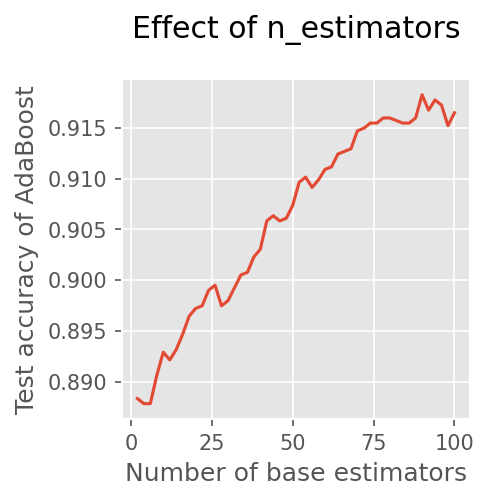

In [405]:
x = list(range(2, 102, 2))
y = []

for i in x:
  adaclf = AdaBoostClassifier(n_estimators=i,
                              learning_rate=0.5,
                              algorithm='SAMME.R',
                              random_state=1)
  
  adaclf.fit(X_train_transformed, y_train)
  adaclf_test_sc = accuracy_score(y_test, adaclf.predict(X_test_transformed))
  y.append(adaclf_test_sc)

plt.style.use('ggplot')

plt.title("Effect of n_estimators", pad=20)
plt.xlabel("Number of base estimators")
plt.ylabel("Test accuracy of AdaBoost")
plt.plot(x, y)

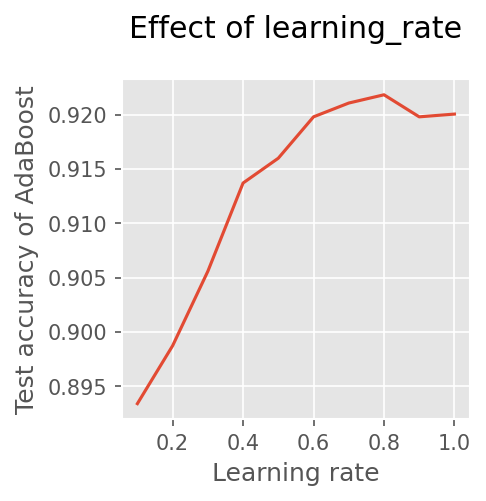

In [411]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
y = []

for i in x:
  adaclf = AdaBoostClassifier(n_estimators=88,
                              learning_rate=i,
                              algorithm='SAMME.R',
                              random_state=1)
  
  adaclf.fit(X_train_transformed, y_train)
  adaclf_test_sc = accuracy_score(y_test, adaclf.predict(X_test_transformed))
  y.append(adaclf_test_sc)

plt.title("Effect of learning_rate", pad=20)
plt.xlabel("Learning rate")
plt.ylabel("Test accuracy of AdaBoost")
plt.plot(x, y)

### Based on the above, the Best Parameters for AdaBoost Classifier are: learning_rate:0.8 and n_estimator = approximately 88

## Cross_validate with AdaBoost Classifier<a id='cv_ada'>

In [408]:
#scoring = {'recall' : make_scorer(recall_score)}


nfold=5
skf = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=False)
Ada_cv = AdaBoostClassifier(algorithm='SAMME.R',n_estimators=88, learning_rate=0.8)
ada_results = cross_validate(estimator=Ada_cv,
                                          X=X_train_transformed,
                                          y=y_train,
                                          cv=skf,
                                          scoring=make_scorer(recall_score, average='weighted', labels=[1]))
print(f'{ada_results}')

{'fit_time': array([16.81474614, 16.96592212, 17.17587709, 16.75732708, 16.14724398]), 'score_time': array([0.09374952, 0.09674883, 0.10074019, 0.09776568, 0.1017251 ]), 'test_score': array([0.51675978, 0.49162011, 0.51117318, 0.50558659, 0.44692737])}


In [409]:
ada_cv_best_scores = ada_results['test_score']
ada_cv_best_scores

array([0.51675978, 0.49162011, 0.51117318, 0.50558659, 0.44692737])

In [410]:
np.mean(ada_cv_best_scores)

0.4944134078212291

## Summary Perfomance of three models 

<table>
    <tr>
        <th>Models</th><th>Recall Score(Original)</th><th>Recall with SMOTE</th><th>Recall with Undersampling</th><th>Recall with StratifiedKFold and tuning</th><th>Best Parameters</th>
    </tr>
    <tr>
        <td>LogisticRegression</td><td>0.46</td><td>0.82</td><td>0.88</td><td>0.61</td><td nowrap=nowrap>{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td><td>0.18</td><td>0.50</td><td>0.88</td><td>0.17</td><td nowrap=nowrap>{'max_features': 'sqrt', 'n_estimators': 200}</td>
    </tr>
     <tr>
        <td>AdaBoostClassifier</td><td>0.50</td><td>0.74</td><td>0.83</td><td>0.49</td><td nowrap=nowrap>{‘n_estimators': 88, 'learning_rate': 0.8}</td>
    </tr>
    </table>